# Hotel Booking Analysis & Demand Insights

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# load
df = pd.read_csv('/kaggle/input/hotel-booking-demand/hotel_bookings.csv')
pd.set_option('display.max_columns', None)

# 1 — Data Preprocessing (cleaning + basic feature engineering)
**1.1 Handle missing values (agent, company, children)**

In [5]:
# Inspect missingness
df[['agent','company','children']].isna().sum()

# children: if missing likely 0 — fill with 0 and convert to int
df['children'] = df['children'].fillna(0).astype(int)

# agent/company: IDs — fill missing with 0 or a sentinel -1 then cast to int
df['agent'] = df['agent'].fillna(0).astype(int)
df['company'] = df['company'].fillna(0).astype(int)


In [6]:
# optional flags to retain missingness signal
df['has_agent'] = (df['agent'] != 0).astype(int)
df['has_company'] = (df['company'] != 0).astype(int)


**1.2 Convert date columns to datetime & derive arrival_date and total_nights**

In [7]:
# Convert reservation_status_date
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

# map month name to number for arrival_date
month_map = {m:i for i,m in enumerate(['January','February','March','April','May','June','July','August','September','October','November','December'],1)}
df['arrival_date_month_num'] = df['arrival_date_month'].map(month_map)

# create arrival_date
df['arrival_date'] = pd.to_datetime(dict(year=df['arrival_date_year'],
                                         month=df['arrival_date_month_num'],
                                         day=df['arrival_date_day_of_month']), errors='coerce')

# create total nights feature
df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']


**1.3 Check & handle duplicates**

In [9]:
# duplicates
dupes = df.duplicated().sum()
print('duplicates:', dupes)
# drop duplicates if any
df = df.drop_duplicates().reset_index(drop=True)


duplicates: 31994


# 2 — Exploratory Data Analysis (Basic Questions)

**Q1: What is the average lead time for bookings?**

In [10]:
avg_lead_time = df['lead_time'].mean()
avg_lead_time


79.89136802599661

**Q2: What is the distribution of bookings by hotel type?**

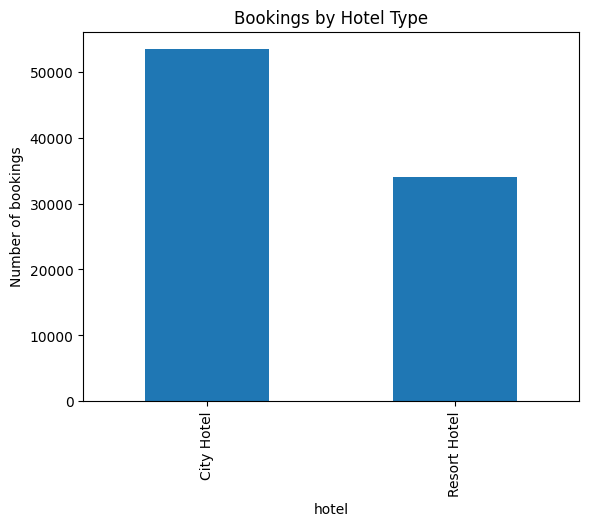

hotel
City Hotel      53428
Resort Hotel    33968
Name: count, dtype: int64

In [11]:
counts_by_hotel = df['hotel'].value_counts()
counts_by_hotel.plot(kind='bar', title='Bookings by Hotel Type')
plt.ylabel('Number of bookings')
plt.show()
counts_by_hotel


**Q3: How many bookings were canceled?**

In [12]:
num_canceled = df['is_canceled'].sum()
pct_canceled = df['is_canceled'].mean() * 100
num_canceled, pct_canceled


(24025, 27.489816467572886)

**Q4: What is the most common arrival month for bookings?**

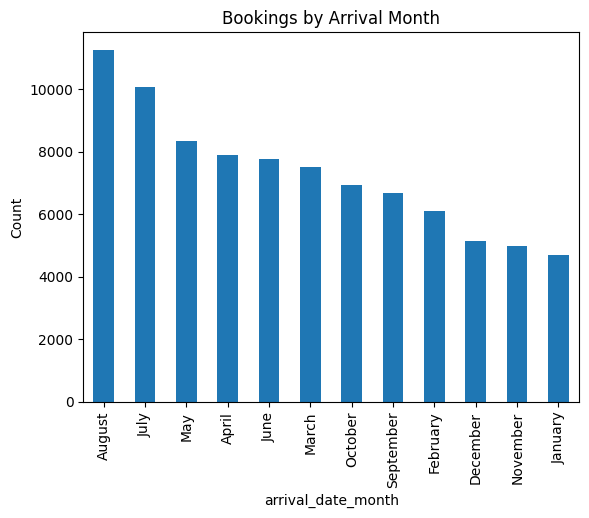

('August',
 arrival_date_month
 August       11257
 July         10057
 May           8355
 April         7908
 June          7765
 March         7513
 October       6934
 September     6690
 February      6098
 December      5131
 November      4995
 January       4693
 Name: count, dtype: int64)

In [13]:
most_common_month = df['arrival_date_month'].mode()[0]
# Or counts:
month_counts = df['arrival_date_month'].value_counts()
month_counts.plot(kind='bar', title='Bookings by Arrival Month')
plt.ylabel('Count')
plt.show()
most_common_month, month_counts


**Q5: What is the average number of special requests per booking?**

In [14]:
avg_special_requests = df['total_of_special_requests'].mean()
avg_special_requests


0.6985674401574443

**Q6: Which country has the highest number of bookings?**

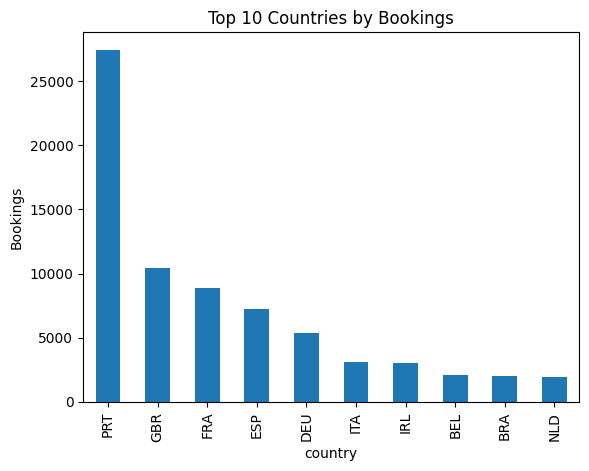

country
PRT    27453
GBR    10433
FRA     8837
ESP     7252
DEU     5387
ITA     3066
IRL     3016
BEL     2081
BRA     1995
NLD     1911
Name: count, dtype: int64

In [15]:
top_countries = df['country'].value_counts().head(10)
top_countries.plot(kind='bar', title='Top 10 Countries by Bookings')
plt.ylabel('Bookings')
plt.show()
top_countries


**Q7: What is the average daily rate (ADR) for each hotel type?**

In [16]:
adr_by_hotel = df.groupby('hotel')['adr'].mean().round(2)
adr_by_hotel


hotel
City Hotel      110.99
Resort Hotel     99.03
Name: adr, dtype: float64

**Q8: What percentage of guests required car parking spaces?**

In [17]:
pct_parking = (df['required_car_parking_spaces'] > 0).mean() * 100
pct_parking


8.367659847132591

**Q9: What is the average stay duration in week nights and weekend nights?**

In [18]:
avg_week_nights = df['stays_in_week_nights'].mean()
avg_weekend_nights = df['stays_in_weekend_nights'].mean()
avg_week_nights, avg_weekend_nights


(2.6253947549086916, 1.005263398782553)

**Q10: How many bookings were made through travel agents?**

In [19]:
# Count bookings with agent ID (non-zero)
bookings_by_agents = (df['agent'] != 0).sum()
bookings_by_agents, (bookings_by_agents / len(df)) * 100


(75203, 86.04856057485468)

# 3 — Medium Level Questions
**Q1: What is the cancellation rate for each hotel type?**

In [20]:
cancel_rate_by_hotel = df.groupby('hotel')['is_canceled'].mean().sort_values(ascending=False)
cancel_rate_by_hotel * 100


hotel
City Hotel      30.038557
Resort Hotel    23.480923
Name: is_canceled, dtype: float64

**Q2: What is the average ADR per market segment?**

In [21]:
adr_by_segment = df.groupby('market_segment')['adr'].mean().sort_values(ascending=False)
adr_by_segment


market_segment
Online TA        118.171606
Direct           116.579429
Aviation         100.170396
Offline TA/TO     81.764191
Groups            74.864284
Corporate         68.151246
Undefined         15.000000
Complementary      3.049245
Name: adr, dtype: float64

**Q3: What is the relationship between lead time and cancellation rate?**

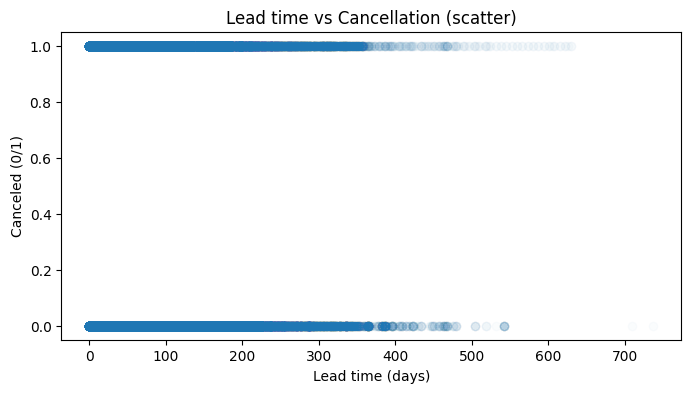

/tmp/ipykernel_48/3300385985.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lead_bin_cancel = df.groupby(bins)['is_canceled'].mean()


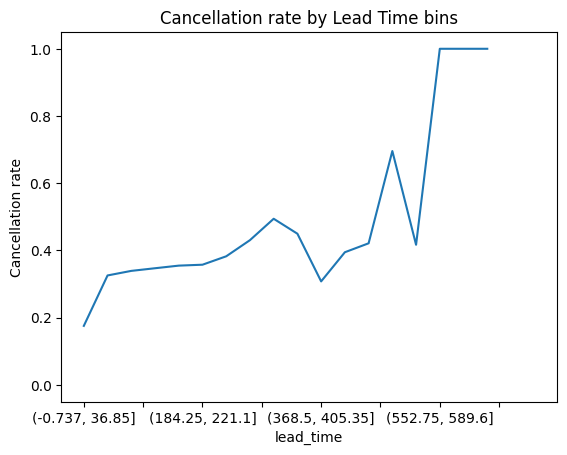

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


lead_time
(-0.737, 36.85]    0.175328
(36.85, 73.7]      0.325398
(73.7, 110.55]     0.338988
(110.55, 147.4]    0.346858
(147.4, 184.25]    0.354627
(184.25, 221.1]    0.357357
(221.1, 257.95]    0.382387
(257.95, 294.8]    0.430430
(294.8, 331.65]    0.494108
(331.65, 368.5]    0.449591
(368.5, 405.35]    0.307692
(405.35, 442.2]    0.394495
(442.2, 479.05]    0.421053
(479.05, 515.9]    0.695652
(515.9, 552.75]    0.416667
(552.75, 589.6]    1.000000
(589.6, 626.45]    1.000000
(626.45, 663.3]    1.000000
(663.3, 700.15]         NaN
(700.15, 737.0]    0.000000
Name: is_canceled, dtype: float64

In [22]:
# scatter (jitter alpha)
plt.figure(figsize=(8,4))
plt.scatter(df['lead_time'], df['is_canceled'], alpha=0.02)
plt.xlabel('Lead time (days)')
plt.ylabel('Canceled (0/1)')
plt.title('Lead time vs Cancellation (scatter)')
plt.show()

# aggregated trend: cancellation rate by lead_time bins
bins = pd.cut(df['lead_time'], bins=20)
lead_bin_cancel = df.groupby(bins)['is_canceled'].mean()
lead_bin_cancel.plot(title='Cancellation rate by Lead Time bins')
plt.ylabel('Cancellation rate')
plt.show()
lead_bin_cancel


**Q4: Which distribution channel has the highest number of bookings?**

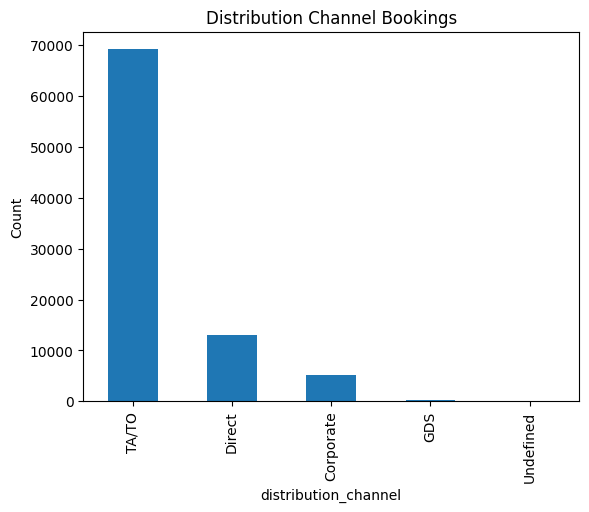

distribution_channel
TA/TO        69141
Direct       12988
Corporate     5081
GDS            181
Undefined        5
Name: count, dtype: int64

In [23]:
dist_counts = df['distribution_channel'].value_counts()
dist_counts.plot(kind='bar', title='Distribution Channel Bookings')
plt.ylabel('Count')
plt.show()
dist_counts


**Q5: What is the average number of previous cancellations by hotel type?**

In [24]:
prev_canc_by_hotel = df.groupby('hotel')['previous_cancellations'].mean()
prev_canc_by_hotel


hotel
City Hotel      0.035768
Resort Hotel    0.021991
Name: previous_cancellations, dtype: float64

**Q6: What is the trend of ADR over the years?**

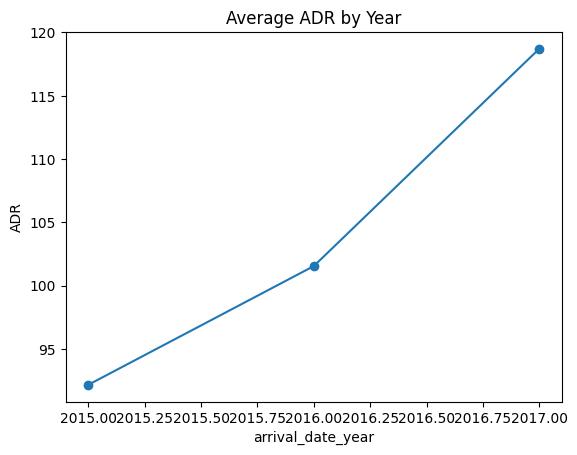

arrival_date_year
2015     92.160752
2016    101.538903
2017    118.710660
Name: adr, dtype: float64

In [25]:
adr_trend = df.groupby('arrival_date_year')['adr'].mean()
adr_trend.plot(marker='o', title='Average ADR by Year')
plt.ylabel('ADR')
plt.show()
adr_trend


**Q7: Which month has the highest revenue?**

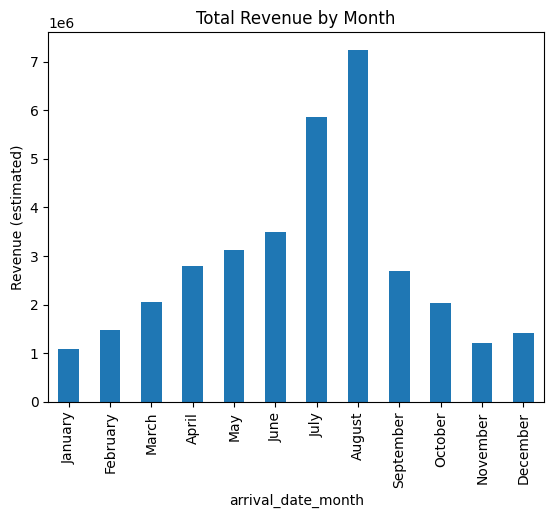

arrival_date_month
August    7240652.99
July      5863024.99
June      3496345.05
Name: revenue, dtype: float64

In [26]:
# estimate revenue per booking
df['revenue'] = df['adr'] * df['total_nights']

monthly_revenue = df.groupby('arrival_date_month')['revenue'].sum().reindex([
    'January','February','March','April','May','June','July','August','September','October','November','December'
])
monthly_revenue.plot(kind='bar', title='Total Revenue by Month')
plt.ylabel('Revenue (estimated)')
plt.show()
monthly_revenue.sort_values(ascending=False).head(3)


**Q8: What is the impact of special requests on ADR?**

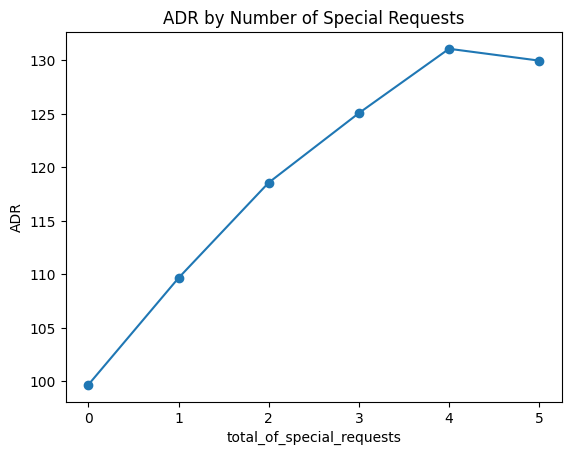

total_of_special_requests
0     99.665633
1    109.651497
2    118.570312
3    125.070790
4    131.088687
5    129.980000
Name: adr, dtype: float64

In [27]:
# average ADR grouped by number of special requests
adr_by_requests = df.groupby('total_of_special_requests')['adr'].mean()
adr_by_requests.plot(marker='o', title='ADR by Number of Special Requests')
plt.ylabel('ADR')
plt.show()
adr_by_requests


**Q9: Average stay duration for repeated guests vs new guests?**

In [28]:
df['stay_len'] = df['total_nights']
avg_stay_by_repeated = df.groupby('is_repeated_guest')['stay_len'].mean()
avg_stay_by_repeated.rename(index={0:'new',1:'repeated'})
avg_stay_by_repeated


is_repeated_guest
0    3.699932
1    1.927086
Name: stay_len, dtype: float64

**Q10: Which room type has the highest number of bookings?**

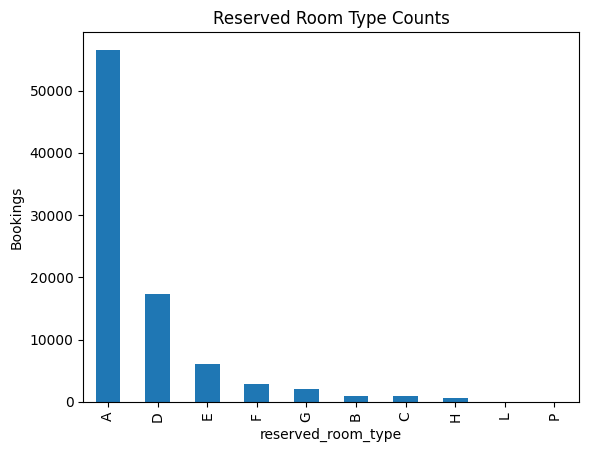

reserved_room_type
A    56552
D    17398
E     6049
F     2823
G     2052
Name: count, dtype: int64

In [29]:
room_counts = df['reserved_room_type'].value_counts()
room_counts.plot(kind='bar', title='Reserved Room Type Counts')
plt.ylabel('Bookings')
plt.show()
room_counts.head(5)


# 4 — Advanced Level Questions
**Q1: What factors significantly impact the cancellation rate? (Logistic regression)**

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report

# select features (example)
features = ['lead_time','total_nights','adr','booking_changes','previous_cancellations','total_of_special_requests','has_agent']
cat_feats = ['market_segment','deposit_type','customer_type','hotel']

# simple pipeline
num_feats = ['lead_time','total_nights','adr','booking_changes','previous_cancellations','total_of_special_requests','has_agent']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_feats),
], remainder='passthrough')  # numeric left

X = df[ num_feats + cat_feats ].copy()
y = df['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipe = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

pipe.fit(X_train, y_train)
y_pred_proba = pipe.predict_proba(X_test)[:,1]
print('ROC AUC:', roc_auc_score(y_test, y_pred_proba))

# get coefficients (approx — careful because onehot expands)
clf = pipe.named_steps['clf']
# We won't try to map all OHE names here, but we can report top numeric coefficients by index:
coef = clf.coef_[0]
# For easier interpretability, get numeric feature coefficients from the end (since remainder='passthrough')
# but this will require retrieving OHE feature count. As a short output:
print('Model trained. Use SHAP or feature importance for detailed interpretability.')


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ROC AUC: 0.7558509031724432
Model trained. Use SHAP or feature importance for detailed interpretability.


**Q2: How does the ADR vary with the number of adults, children, and babies? (Multiple regression)**

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# simple features
X = df[['adults','children','babies','total_nights','hotel','market_segment']].copy()
y = df['adr']

# simple OHE for categorical, train/test
X = pd.get_dummies(X, columns=['hotel','market_segment'], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X.fillna(0), y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print('RMSE ADR:', mean_squared_error(y_test, pred, squared=False))
# feature importance
fi = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10)
fi


RMSE ADR: 40.85780713422261


children                        0.289161
adults                          0.279955
market_segment_Online TA        0.110824
total_nights                    0.096628
hotel_Resort Hotel              0.065184
market_segment_Direct           0.059690
market_segment_Complementary    0.058062
market_segment_Offline TA/TO    0.027666
market_segment_Groups           0.010381
babies                          0.001262
dtype: float64

**Q3: What is the impact of booking changes on guest satisfaction as indicated by special requests?**

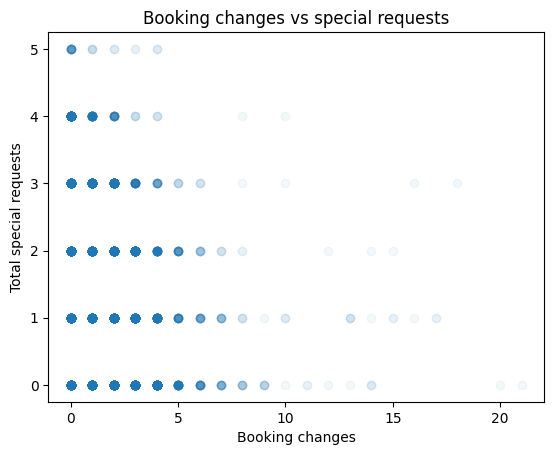

In [32]:
# correlation
corr = df['booking_changes'].corr(df['total_of_special_requests'])
corr
# visualize
plt.scatter(df['booking_changes'], df['total_of_special_requests'], alpha=0.05)
plt.xlabel('Booking changes')
plt.ylabel('Total special requests')
plt.title('Booking changes vs special requests')
plt.show()


**Q4: What is the seasonal impact on booking cancellations?**

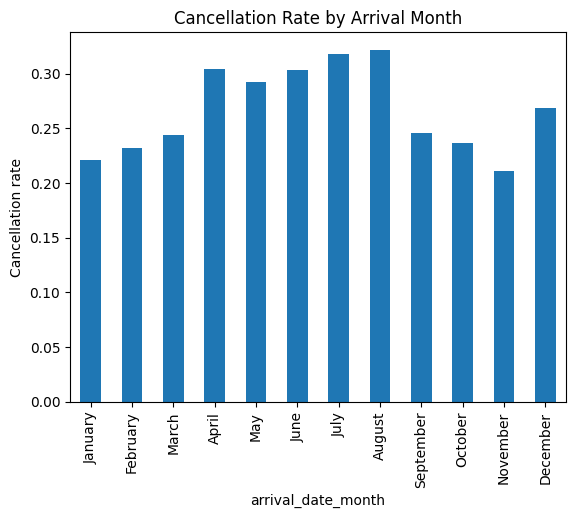

arrival_date_month
January      0.221180
February     0.232043
March        0.243578
April        0.304628
May          0.292280
June         0.303155
July         0.317987
August       0.321844
September    0.245441
October      0.236804
November     0.211011
December     0.268564
Name: is_canceled, dtype: float64

In [33]:
# cancellation rate per month (use arrival_date_month ordered)
cancel_by_month = df.groupby('arrival_date_month')['is_canceled'].mean().reindex([
    'January','February','March','April','May','June','July','August','September','October','November','December'
])
cancel_by_month.plot(kind='bar', title='Cancellation Rate by Arrival Month')
plt.ylabel('Cancellation rate')
plt.show()
cancel_by_month


**Q5: How does lead time distribution vary across market segments?**

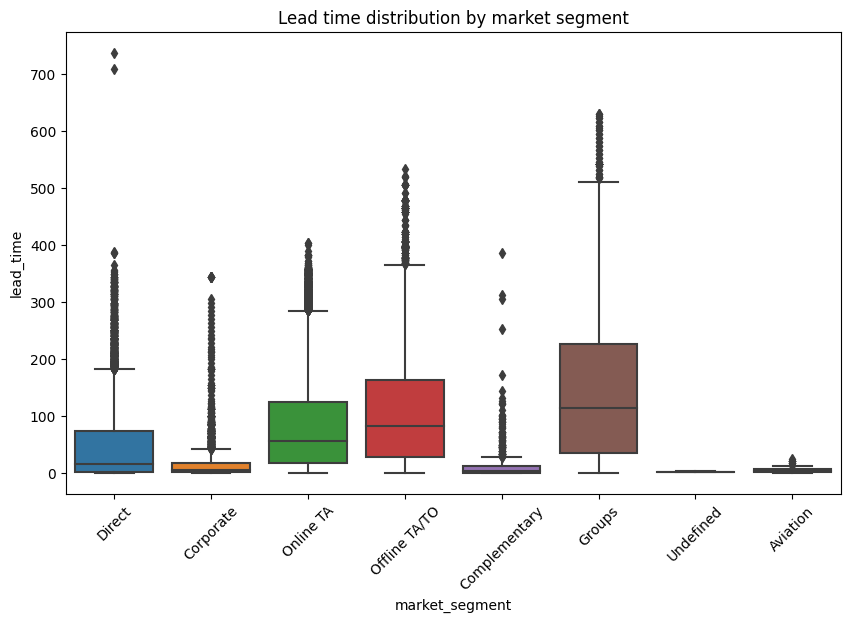

In [34]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.boxplot(x='market_segment', y='lead_time', data=df)
plt.xticks(rotation=45)
plt.title('Lead time distribution by market segment')
plt.show()


# 5 — Final tips & reproducibility

In [35]:
df.to_csv('hotel_bookings_cleaned.csv', index=False)
